## [Dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification)

# Genre Predictor


## **Objective** 

The goal of this project is to build a system that can classify music genres based on audio features extracted from songs. For this, we’re using the GTZAN dataset, which contains tracks labeled across 10 genres, such as Blues, Jazz, Rock, and Classical. The project involves analyzing the dataset to uncover patterns in the audio features that can help distinguish one genre from another.

This work has practical applications in many areas. For example, music streaming platforms could use a system like this to improve their recommendation algorithms by better understanding the genres of songs. It could also help organize large music libraries by automatically tagging tracks with the correct genre, saving time and reducing human errors. Beyond that, it could provide insights into genre trends, which could be useful for the music industry in understanding listener preferences and market dynamics.

Our ultimate goal is to develop a system that is both accurate and insightful, demonstrating the potential of audio-based classification for real-world use cases. Along the way, we’ll focus on understanding how audio features correlate with genre characteristics and how to improve the system’s accuracy through experimentation and optimization.




#### Imports:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# **Get The Data**

#### *Loading the data*

In [2]:
# Function to load the dataset
def load_dataset(dataset_name=None):
    return pd.read_csv(f'data/{dataset_name}')

In [3]:
data = load_dataset('features_30_sec.csv')

In [4]:
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             


#### *Data Overview*

- The dataset contains audio features including spectral measurements, MFCCs, and temporal characteristics with no missing values.


| Feature | Description |
|---------|------------|
| chroma_stft | Represents pitch content by mapping spectral data into 12 pitch classes |
| rms | Root Mean Square energy - represents the loudness/volume of the audio |
| spectral_centroid | Indicates where the "center of mass" of the sound is - relates to sound brightness |
| spectral_bandwidth | Width of the spectrum - indicates the range of frequencies |
| rolloff | Frequency below which most of the signal's energy is contained |
| zero_crossing_rate | Rate at which the signal changes from positive to negative - relates to noisiness |
| harmony | Measure of harmonic content vs noise in the signal |
| perceptr | Perceptual features of the sound |
| tempo | Speed/pace of the music in beats per minute |
| mfcc1-20 | Mel-frequency cepstral coefficients - represent the overall shape of the spectral envelope |

Note: Each feature has both _mean and _var (variance) measurements, representing the average value and how much it varies throughout the audio sample.


- 1,000 entries with 60 columns
- All data fields are completely populated
- Data types:
  - float64: 57 columns (audio features)
  - int64: 1 column (length)
  - object: 2 columns (filename, label)



In [6]:
data.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,661794.000000,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,675808.000000,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


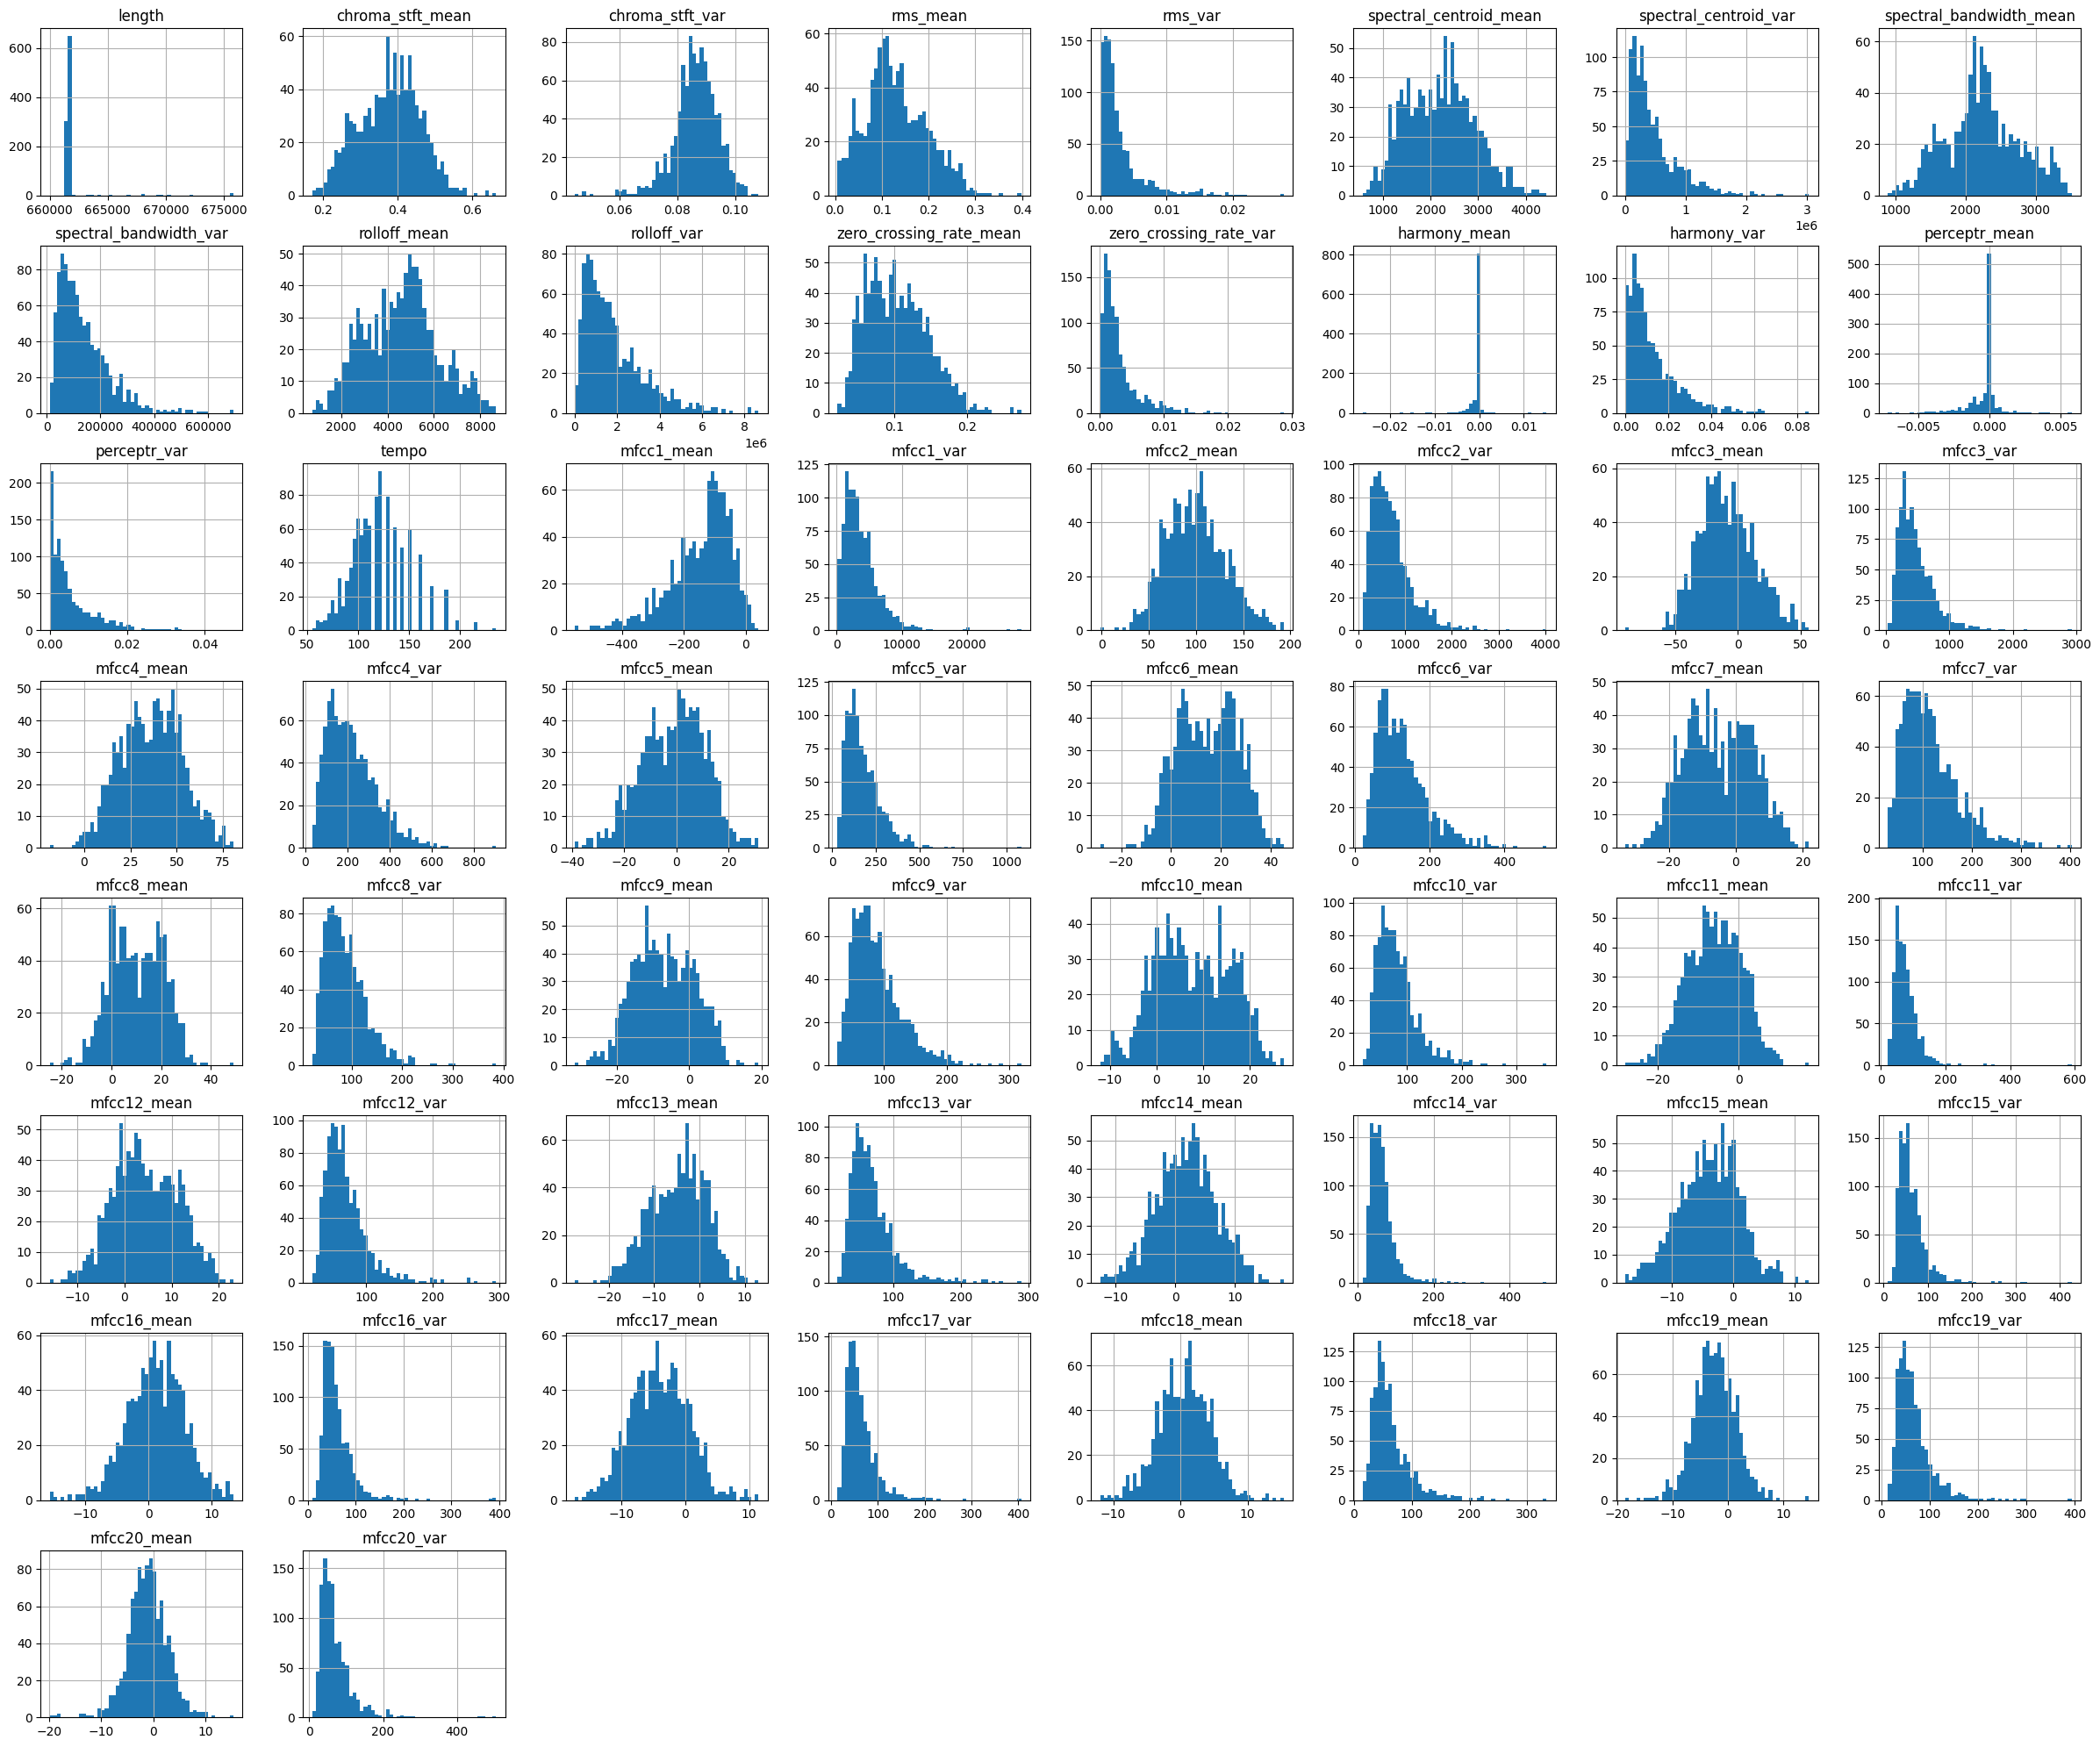

In [13]:
data.hist(bins=50, figsize=(30,25));

### *Splitting The Data Into Two Subsets*

-  The `train_set` containing 80% of the data for training and `test_set` containing 20% for testing, with the split being reproducible due to the specified `random_state`.

In [6]:
# Split the data into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
data = train

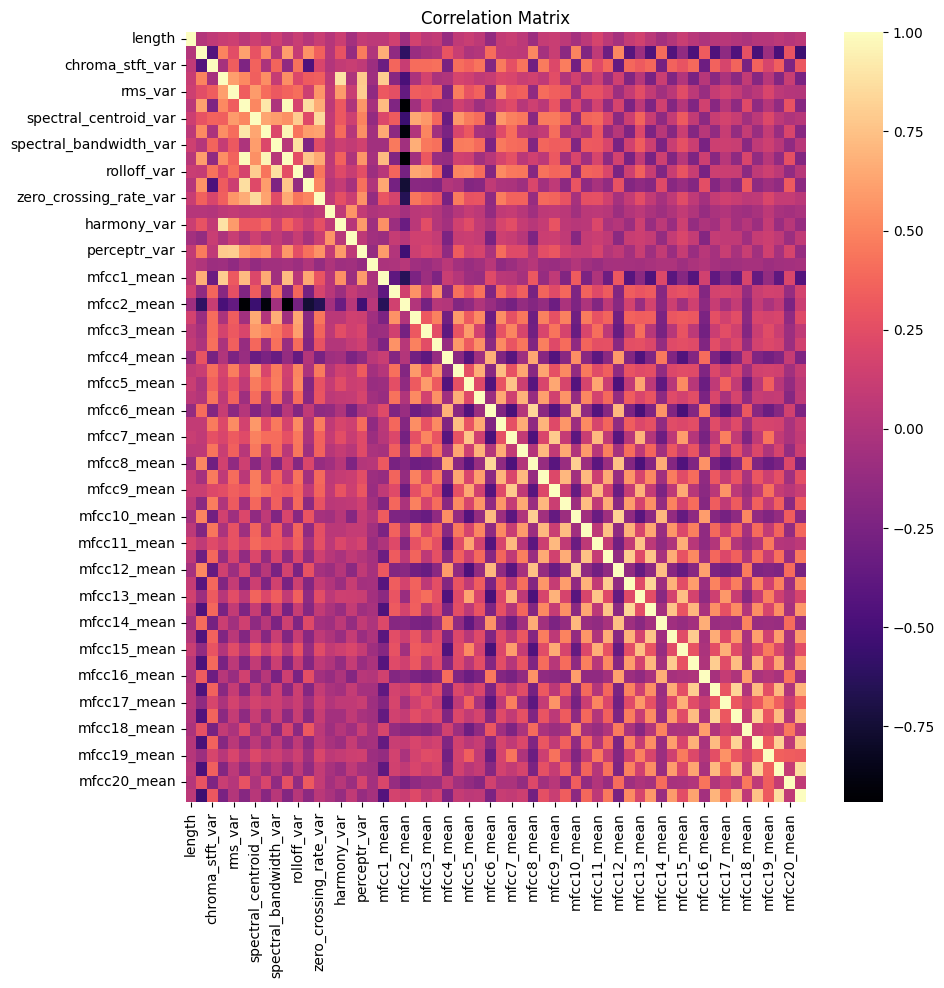

In [7]:
numeric_columns = data.select_dtypes(include=[np.number])

# Corelation matrix with sns
corr = numeric_columns.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=False, cmap='magma')
plt.title('Correlation Matrix')
plt.show()


In [8]:
X = train.drop(columns=['label'])
y = train['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

X = X.drop(columns=['filename'])

X_test = X_test.drop(columns=['filename'])

In [ ]:
params = {
    'n_estimators': [10, 25, 50, 100],
    'learning_rate': [0.1, 0.3, 0.5],
    'max_depth': [1, 2, 3, 4]
}

gbc = GradientBoostingClassifier()

gs = GridSearchCV(gbc, param_grid=params, cv=5, n_jobs=-1, scoring='recall_macro')

gs.fit(X, y)

gs.predict(X_test)

print(gs.best_params_)
print(gs.best_score_)

report = classification_report(y_test, gs.predict(X_test))
print(report)

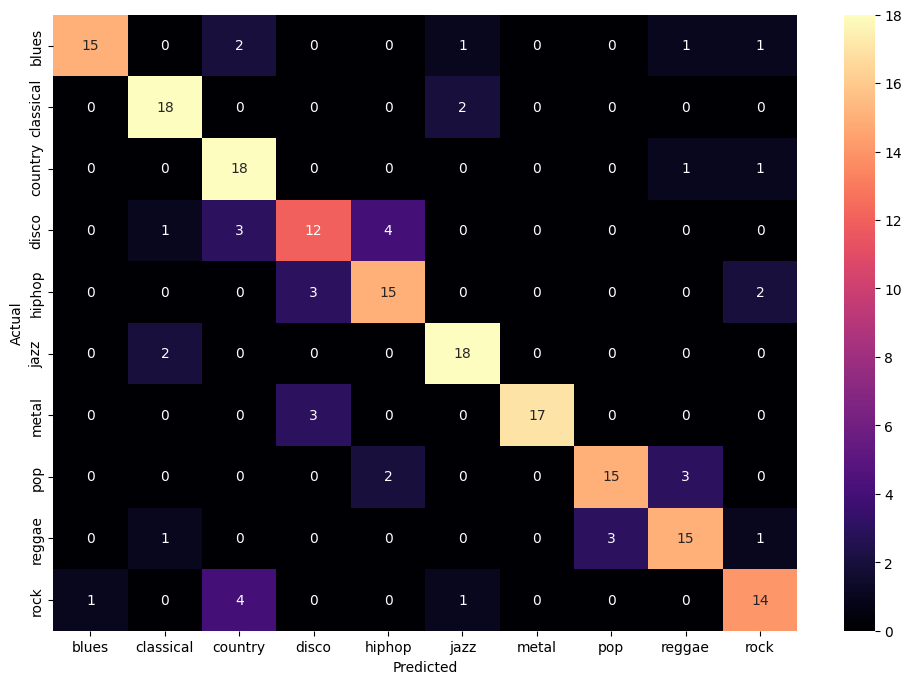

In [ ]:
# graphing the decision, what the model predicted vs that actual value
cm = confusion_matrix(y_test, gs.predict(X_test))
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap='magma', xticklabels=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'], yticklabels=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

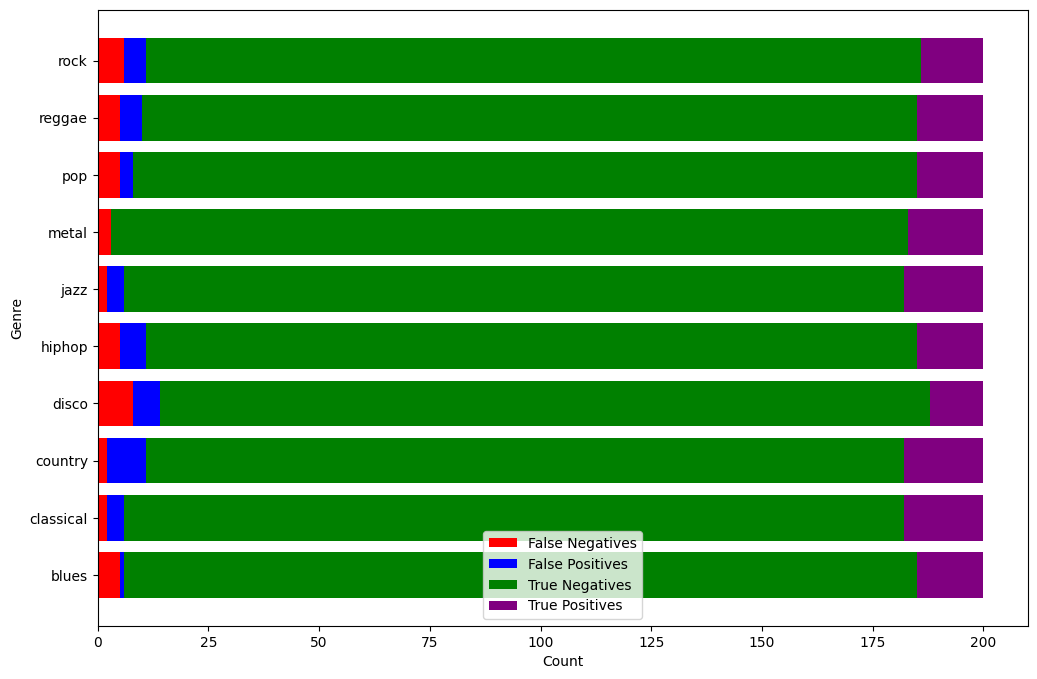

In [ ]:
false_negatives = []
false_positives = []
true_negatives = []
true_positives = []

for i in range(10):
    false_negatives.append(cm[i].sum() - cm[i][i])
    false_positives.append(cm[:, i].sum() - cm[i][i])
    true_negatives.append(sum(np.delete(np.delete(cm, i, axis=0), i, axis=1).flatten()))
    true_positives.append(cm[i][i])

plt.figure(figsize=(12, 8))
plt.barh(np.arange(10), false_negatives, color='red', label='False Negatives')
plt.barh(np.arange(10), false_positives, left=false_negatives, color='blue', label='False Positives')
plt.barh(np.arange(10), true_negatives, left=np.add(false_negatives, false_positives), color='green', label='True Negatives')
plt.barh(np.arange(10), true_positives, left=np.add(np.add(false_negatives, false_positives), true_negatives), color='purple', label='True Positives')
plt.yticks(np.arange(10), ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
plt.xlabel('Count')
plt.ylabel('Genre')
plt.legend()
plt.show()